Import Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve)

Load Datasets

In [5]:
X_train = pd.read_csv("../../../Data/processed/baseline_splits/train_X.csv")
Y_train = pd.read_csv("../../../Data/processed/baseline_splits/train_y.csv")
X_test = pd.read_csv("../../../Data/processed/baseline_splits/test_X.csv")
Y_test = pd.read_csv("../../../Data/processed/baseline_splits/test_y.csv")

Check Shapes of Datasets

In [6]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (9754760, 19)
Y_train shape: (9754760, 1)
X_test shape: (2438690, 19)
Y_test shape: (2438690, 1)


Undersampling (10% fraudulent transactions)

In [7]:
rus = RandomUnderSampler(sampling_strategy=0.10, random_state=42)
X_train_res, Y_train_res = rus.fit_resample(X_train, Y_train.values.ravel())

Check Distrubution after Undersampling

In [8]:
print("Resampled X shape:", X_train_res.shape)
print("Resampled y shape:", Y_train_res.shape)
print("Class distribution after resampling:")
print(pd.Series(Y_train_res).value_counts())


Resampled X shape: (129635, 19)
Resampled y shape: (129635,)
Class distribution after resampling:
0    117850
1     11785
Name: count, dtype: int64


Encoding

In [9]:
X_train_enc = X_train_res.copy()
X_test_enc  = X_test.copy()

for col in X_train_enc.columns:
    if X_train_enc[col].dtype == "object":
        # Factorize train
        codes, uniques = pd.factorize(X_train_enc[col])
        X_train_enc[col] = codes
        # Map test values, unseen categories → -1
        mapping = {cat: code for code, cat in enumerate(uniques)}
        X_test_enc[col] = X_test_enc[col].map(mapping).fillna(-1)

Fill NaNs in Train and Test Sets


In [10]:
X_train_enc = X_train_enc.fillna(-1)
X_test_enc  = X_test_enc.fillna(-1)

Logistic Regression Implementation

In [11]:
log_reg = LogisticRegression(max_iter=500, n_jobs=-1)
log_reg.fit(X_train_enc, Y_train_res)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


Predictions

In [12]:
y_pred = log_reg.predict(X_test_enc)
y_prob = log_reg.predict_proba(X_test_enc)[:, 1]

Confusion Matrix

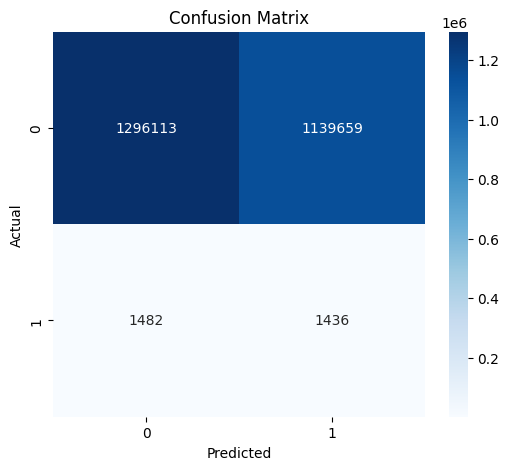

In [ ]:
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
plt.savefig("/content/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.close()

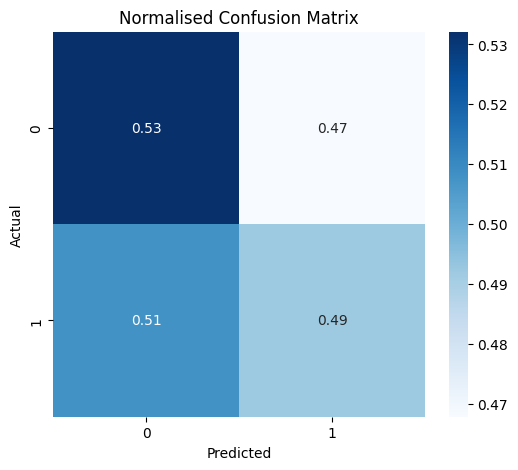

In [19]:
cm_norm = confusion_matrix(Y_test, y_pred, normalize="true")
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalised Confusion Matrix")
plt.show()
plt.close()

Classification Report

In [ ]:
clf_report = classification_report(Y_test, y_pred)
print(clf_report)

# Save classification report as text file
with open("/content/classification_report.txt", "w") as f:
    f.write(clf_report)

              precision    recall  f1-score   support

           0       1.00      0.53      0.69   2435772
           1       0.00      0.49      0.00      2918

    accuracy                           0.53   2438690
   macro avg       0.50      0.51      0.35   2438690
weighted avg       1.00      0.53      0.69   2438690



ROC Curve

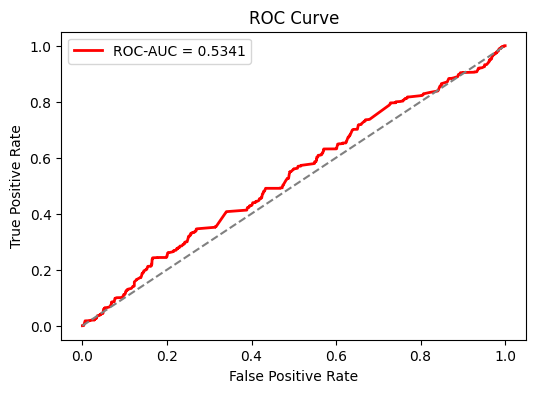

In [ ]:
roc_auc = roc_auc_score(Y_test, y_prob)
fpr, tpr, _ = roc_curve(Y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="r", lw=2, label=f"ROC-AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
plt.savefig("/content/roc_curve.png", dpi=300, bbox_inches='tight')
plt.close()

Precision-Recall Curve

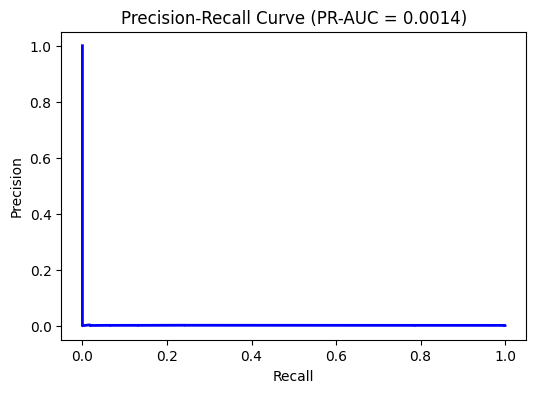

In [ ]:
pr_auc = average_precision_score(Y_test, y_prob)
precision, recall, thresholds = precision_recall_curve(Y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, color="b", lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (PR-AUC = {pr_auc:.4f})")
plt.show()
plt.savefig("/content/pr_curve.png", dpi=300, bbox_inches='tight')
plt.close()

Metrics

In [ ]:
print("ROC-AUC:", roc_auc)
print("PR-AUC:", pr_auc)

ROC-AUC: 0.5341106895086065
PR-AUC: 0.001379866269794039


Done